### Summary of Notebook
This notebook details the hyperparameter tuning, training and evaluation processes for the original MobileNet_V3_Small on the flowers102 dataset The tuning is conducted using Ray Tune alongside PyTorch to optimize the performance of these models.

In [6]:
import torchvision
from torchvision import datasets, transforms
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.models import mobilenet_v3_small
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import ray
from ray import tune
from ray import train
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.train import Checkpoint, get_checkpoint
import ray.cloudpickle as pickle
from functools import partial
import os
import sys
import tempfile
working_dir = "C:/Users/fooji/OneDrive/School/Y4S1/FYP/FYP"
sys.path.append(working_dir)
from utils.NNModules import MobileNetV3Small, MobileNetV3SmallQuadrant
from utils.model_training import train_model

### Set Up
Here, we will begin by initialising the ray module and setting the working directory as the root directory of the repository.

In [2]:
ray.shutdown()
ray.init(runtime_env={"working_dir":working_dir,
                      "excludes": ["/data"]
})

2024-09-11 14:58:08,297	INFO worker.py:1783 -- Started a local Ray instance.
2024-09-11 14:58:08,516	INFO packaging.py:530 -- Creating a file package for local directory 'C:/Users/fooji/OneDrive/School/Y4S1/FYP/FYP'.
2024-09-11 14:58:08,596	WARNING packaging.py:405 -- File C:\Users\fooji\OneDrive\School\Y4S1\FYP\FYP\scripts\benchmark\mobilenet_v3_small\flowers\mobilenet_v3_small_quadrant.ipynb is very large (12.24MiB). Consider adding this file to the 'excludes' list to skip uploading it: `ray.init(..., runtime_env={'excludes': ['C:\Users\fooji\OneDrive\School\Y4S1\FYP\FYP\scripts\benchmark\mobilenet_v3_small\flowers\mobilenet_v3_small_quadrant.ipynb']})`
2024-09-11 14:58:08,767	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_9cb9fc24404e506a.zip' (23.12MiB) to Ray cluster...
2024-09-11 14:58:09,048	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_9cb9fc24404e506a.zip'.


Python version:,3.10.12
Ray version:,2.35.0


We will create a function to retrieve the flowers102 dataset and do the necessary transformations

In [2]:
def load_data(data_dir="./../../../../data/flowers"):
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    train_dataset = torchvision.datasets.Flowers102(data_dir + "/train", split="train", download=True, transform=data_transforms["train"])
    val_dataset = torchvision.datasets.Flowers102(data_dir + "/val", split="val", download=True, transform=data_transforms["val"])
    test_dataset = torchvision.datasets.Flowers102(data_dir + "/test", split="test", download=True, transform=data_transforms["test"])
    return train_dataset, val_dataset, test_dataset

### Hyperparamater Tuning

The following section performs comprehensive hyperparameter tuning according to the user-provided configuration for the chosen model.

In [4]:
def train_flowers(config, model_name, data_dir=None):
    train_dataset, val_dataset, _= load_data(data_dir)
    model = None
    if model_name == "MobileNetV3Small":
        model = MobileNetV3Small(num_classes=102)
    elif model_name == "MobileNetV3SmallQuadrant":
        model = MobileNetV3SmallQuadrant(num_classes=102)
    else:
        raise ValueError(f"Model {model_name} is not implemented. Supported models are 'MobileNetV3Small' and 'MobileNetV3SmallQuadrant'.")
    device = "cpu"
    if torch.cuda.is_available():
        device="cuda:0"
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss(reduction='sum')
    optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"], momentum=0.9)
    checkpoint = get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                checkpoint_state = pickle.load(fp)
            start_epoch = checkpoint_state["epoch"]
            model.load_state_dict(checkpoint_state["model_state_dict"])
            optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=True)
    for epoch in range(30):
        train_running_loss = 0.0
        train_correct = 0
        model.train()
        with torch.autograd.set_detect_anomaly(True):
            for i, data in enumerate(train_dataloader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs,1)
                train_correct += torch.sum(preds==labels.data)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_running_loss += loss.item()
        print(f'Train Loss: {train_running_loss/len(train_dataloader.dataset):.4f} Acc: {train_correct/len(train_dataloader.dataset):.4f}')
        val_running_loss = 0.0
        val_correct = 0
        model.eval()
        for i, data in enumerate(val_dataloader):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds==labels.data)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        checkpoint_data = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        with tempfile.TemporaryDirectory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "wb") as fp:
                pickle.dump(checkpoint_data, fp)

            checkpoint = Checkpoint.from_directory(checkpoint_dir)
            train.report(
                {"loss": val_running_loss / len(val_dataloader.dataset), "accuracy": float(val_correct / len(val_dataloader.dataset))},
                checkpoint=checkpoint,
            )
    print("Finished Training")

In [13]:
def test_accuracy(model, device="cpu"):
    _, _, test_dataset= load_data()
    correct = 0
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)
    model.eval()
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
    print(f"Number of correct preds: {correct}")
    print(f"Test dataset total rows: {len(test_dataloader.dataset)}")
    return float(correct/len(test_dataloader.dataset))

In [6]:
def main(model_name, num_samples=8, max_num_epochs=30, gpus_per_trial=0):
    data_dir = os.path.abspath("./../../../../data/flowers")
    config={
        "lr":tune.loguniform(1e-4, 1e-3),
        "batch_size": tune.choice([16,32])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=2,
        reduction_factor=2
    )
    reporter = CLIReporter(
        metric_columns=["loss", "accuracy", "training_iteration"]
    )
    result = tune.run(
        partial(train_flowers, model_name=model_name, data_dir=data_dir),
        resources_per_trial = {"cpu":2, "gpu":gpus_per_trial},
        config=config,
        num_samples = num_samples,
        scheduler=scheduler,
        progress_reporter=reporter
    )
    best_trial = result.get_best_trial("loss", "min", "last")
    print(f"Best Trial Config: {best_trial.config}")
    print(f"Best Trial Final Validation Loss: {best_trial.last_result['loss']}")
    print(f"Best Trial Final Validation Accuracy: {best_trial.last_result['accuracy']}")
    best_trained_model = None
    if model_name == "MobileNetV3Small":
        best_trained_model = MobileNetV3Small(num_classes=102)
    elif model_name == "MobileNetV3SmallQuadrant":
        best_trained_model = MobileNetV3SmallQuadrant(num_classes=102)
    else:
        raise ValueError(f"Model {model_name} is not implemented. Supported models are 'MobileNetV3Small' and 'MobileNetV3SmallQuadrant'.")
    device="cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
    best_trained_model.to(device)
    best_checkpoint = result.get_best_checkpoint(trial=best_trial, metric="accuracy", mode="max")
    with best_checkpoint.as_directory() as checkpoint_dir:
        data_path = Path(checkpoint_dir) / "data.pkl"
        print(f"This is the best checkpoint path {data_path}")
    with open(data_path, "rb") as fp:
        best_checkpoint_data = pickle.load(fp)
    best_trained_model.load_state_dict(best_checkpoint_data["model_state_dict"])
    test_acc = test_accuracy(best_trained_model, device)
    print("Best Trial Test Set Accuracy: {}".format(test_acc))

In [8]:
main(model_name="MobileNetV3Small", num_samples=16, max_num_epochs=25, gpus_per_trial=0)

2024-09-10 00:11:09,985	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2024-09-10 00:11:10 (running for 00:00:00.32)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None
Logical resource usage: 0/8 CPUs, 0/0 GPUs
Result logdir: C:/Users/fooji/AppData/Local/Temp/ray/session_2024-09-09_18-55-01_167056_18296/artifacts/2024-09-10_00-11-10/train_flowers_2024-09-10_00-11-10/driver_artifacts
Number of trials: 16/16 (16 PENDING)


== Status ==
Current time: 2024-09-10 00:11:15 (running for 00:00:05.35)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None
Logical resource usage: 8.0/8 CPUs, 0/0 GPUs
Result logdir: C:/Users/fooji/AppData/Local/Temp/ray/session_2024-09-09_18-55-01_167056_18296/artifacts/2024-09-10_00-11-10/train_flowers_2024-09-10_00-11-10/driver_artifacts
Number of trials: 16/16 (16 PENDING)


== Status ==
Current time: 2024-09-10 00:11:20 (running for 00:00:10.40)
Using AsyncHyperBand: num

(func pid=19344) Train Loss: 6.0769 Acc: 0.0176
(func pid=332) Train Loss: 5.6342 Acc: 0.0304
(func pid=2412) Train Loss: 5.7208 Acc: 0.0265


Trial name,accuracy,loss,should_checkpoint
train_flowers_20865_00000,0.0333333,6.73947,True
train_flowers_20865_00001,0.772549,0.995328,True
train_flowers_20865_00002,0.782353,0.864325,True
train_flowers_20865_00003,0.667647,1.60751,True
train_flowers_20865_00004,0.189216,3.79313,True
train_flowers_20865_00005,0.609804,1.78513,True
train_flowers_20865_00006,0.0166667,6.0398,True
train_flowers_20865_00007,0.185294,4.36744,True
train_flowers_20865_00008,0.0558824,6.6746,True
train_flowers_20865_00009,0.747059,1.10183,True


(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000000)
(func pid=332) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00000_0_batch_size=16,lr=0.0008_2024-09-10_00-11-10/checkpoint_000000)
(func pid=2412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00001_1_batch_size=16,lr=0.0005_2024-09-10_00-11-10/checkpoint_000000)


== Status ==
Current time: 2024-09-10 00:14:37 (running for 00:03:27.13)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None
Logical resource usage: 8.0/8 CPUs, 0/0 GPUs
Result logdir: C:/Users/fooji/AppData/Local/Temp/ray/session_2024-09-09_18-55-01_167056_18296/artifacts/2024-09-10_00-11-10/train_flowers_2024-09-10_00-11-10/driver_artifacts
Number of trials: 16/16 (12 PENDING, 4 RUNNING)


== Status ==
Current time: 2024-09-10 00:14:42 (running for 00:03:32.14)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None
Logical resource usage: 8.0/8 CPUs, 0/0 GPUs
Result logdir: C:/Users/fooji/AppData/Local/Temp/ray/session_2024-09-09_18-55-01_167056_18296/artifacts/2024-09-10_00-11-10/train_flowers_2024-09-10_00-11-10/driver_artifacts
Number of trials: 16/16 (12 PENDING, 4 RUNNING)


== Status ==
Current time: 2024-09-10 00:14:47 (running for 00:03:37.17)
U

(func pid=19344) Train Loss: 4.3558 Acc: 0.0912 [repeated 2x across cluster]
(func pid=2412) Train Loss: 3.9624 Acc: 0.1412
(func pid=332) Train Loss: 4.3027 Acc: 0.0882


(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000001) [repeated 2x across cluster]
(func pid=2412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00001_1_batch_size=16,lr=0.0005_2024-09-10_00-11-10/checkpoint_000001)
(func pid=332) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00000_0_batch_size=16,lr=0.0008_2024-09-10_00-11-10/checkpoint_000001)


(func pid=19344) Train Loss: 3.6021 Acc: 0.1980 [repeated 2x across cluster]


(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000002) [repeated 2x across cluster]


(func pid=2412) Train Loss: 3.1383 Acc: 0.2471
(func pid=17084) Train Loss: 3.6344 Acc: 0.2039
(func pid=17640) Train Loss: 7.2331 Acc: 0.0059


(func pid=2412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00001_1_batch_size=16,lr=0.0005_2024-09-10_00-11-10/checkpoint_000002)
(func pid=17084) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00002_2_batch_size=16,lr=0.0001_2024-09-10_00-11-10/checkpoint_000002)
(func pid=17640) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00004_4_batch_size=32,lr=0.0001_2024-09-10_00-11-10/checkpoint_000000)


(func pid=19344) Train Loss: 2.8723 Acc: 0.3137


(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000003)


(func pid=2412) Train Loss: 2.3860 Acc: 0.4010
(func pid=17084) Train Loss: 2.9360 Acc: 0.3451
(func pid=17640) Train Loss: 4.8875 Acc: 0.0578


(func pid=2412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00001_1_batch_size=16,lr=0.0005_2024-09-10_00-11-10/checkpoint_000003)
(func pid=17084) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00002_2_batch_size=16,lr=0.0001_2024-09-10_00-11-10/checkpoint_000003)
(func pid=17640) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00004_4_batch_size=32,lr=0.0001_2024-09-10_00-11-10/checkpoint_000001)


(func pid=19344) Train Loss: 2.2721 Acc: 0.4216


(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000004)


(func pid=17640) Train Loss: 3.9808 Acc: 0.1559
(func pid=17084) Train Loss: 2.3784 Acc: 0.4461


(func pid=17640) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00004_4_batch_size=32,lr=0.0001_2024-09-10_00-11-10/checkpoint_000002)
(func pid=17084) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00002_2_batch_size=16,lr=0.0001_2024-09-10_00-11-10/checkpoint_000004)


(func pid=19344) Train Loss: 1.9998 Acc: 0.4804 [repeated 2x across cluster]


(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000005) [repeated 2x across cluster]


(func pid=17640) Train Loss: 3.2720 Acc: 0.2637
(func pid=17084) Train Loss: 1.8974 Acc: 0.5490


(func pid=17640) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00004_4_batch_size=32,lr=0.0001_2024-09-10_00-11-10/checkpoint_000003)
(func pid=17084) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00002_2_batch_size=16,lr=0.0001_2024-09-10_00-11-10/checkpoint_000005)


(func pid=19344) Train Loss: 1.5223 Acc: 0.5912 [repeated 2x across cluster]


(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000006) [repeated 2x across cluster]


(func pid=17084) Train Loss: 1.6275 Acc: 0.6000
(func pid=2412) Train Loss: 1.3989 Acc: 0.6441
(func pid=18664) Train Loss: 5.6609 Acc: 0.0304


(func pid=17084) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00002_2_batch_size=16,lr=0.0001_2024-09-10_00-11-10/checkpoint_000006)
(func pid=2412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00001_1_batch_size=16,lr=0.0005_2024-09-10_00-11-10/checkpoint_000006)
(func pid=18664) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00005_5_batch_size=16,lr=0.0006_2024-09-10_00-11-10/checkpoint_000000)


(func pid=19344) Train Loss: 1.3477 Acc: 0.6333


(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000007)


(func pid=17084) Train Loss: 1.3573 Acc: 0.6706
(func pid=2412) Train Loss: 1.0391 Acc: 0.7176
(func pid=18664) Train Loss: 3.7426 Acc: 0.1686


(func pid=17084) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00002_2_batch_size=16,lr=0.0001_2024-09-10_00-11-10/checkpoint_000007)
(func pid=2412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00001_1_batch_size=16,lr=0.0005_2024-09-10_00-11-10/checkpoint_000007)
(func pid=18664) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00005_5_batch_size=16,lr=0.0006_2024-09-10_00-11-10/checkpoint_000001)


(func pid=19344) Train Loss: 1.3052 Acc: 0.6549


(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000008)


(func pid=2412) Train Loss: 0.9506 Acc: 0.7382
(func pid=17084) Train Loss: 1.2500 Acc: 0.6755
(func pid=18664) Train Loss: 2.5695 Acc: 0.3735


(func pid=2412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00001_1_batch_size=16,lr=0.0005_2024-09-10_00-11-10/checkpoint_000008)
(func pid=17084) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00002_2_batch_size=16,lr=0.0001_2024-09-10_00-11-10/checkpoint_000008)
(func pid=18664) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00005_5_batch_size=16,lr=0.0006_2024-09-10_00-11-10/checkpoint_000002)


(func pid=19344) Train Loss: 1.0499 Acc: 0.7049


(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000009)


(func pid=2412) Train Loss: 0.9314 Acc: 0.7363
(func pid=17084) Train Loss: 1.0313 Acc: 0.7392


(func pid=2412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00001_1_batch_size=16,lr=0.0005_2024-09-10_00-11-10/checkpoint_000009)
(func pid=17084) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00002_2_batch_size=16,lr=0.0001_2024-09-10_00-11-10/checkpoint_000009)


(func pid=19344) Train Loss: 0.8869 Acc: 0.7716 [repeated 2x across cluster]


(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000010) [repeated 2x across cluster]


(func pid=17084) Train Loss: 0.9333 Acc: 0.7627
(func pid=2412) Train Loss: 0.8537 Acc: 0.7725


(func pid=2412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00001_1_batch_size=16,lr=0.0005_2024-09-10_00-11-10/checkpoint_000010)
(func pid=17084) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00002_2_batch_size=16,lr=0.0001_2024-09-10_00-11-10/checkpoint_000010)


(func pid=19344) Train Loss: 0.7662 Acc: 0.7931 [repeated 2x across cluster]


(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000011) [repeated 2x across cluster]


(func pid=17084) Train Loss: 0.8510 Acc: 0.7794
(func pid=2412) Train Loss: 0.7545 Acc: 0.7902
(func pid=19344) Train Loss: 0.5926 Acc: 0.8471 [repeated 2x across cluster]


(func pid=17084) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00002_2_batch_size=16,lr=0.0001_2024-09-10_00-11-10/checkpoint_000011)
(func pid=2412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00001_1_batch_size=16,lr=0.0005_2024-09-10_00-11-10/checkpoint_000011)
(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000012) [repeated 2x across cluster]


(func pid=18664) Train Loss: 1.0143 Acc: 0.7284
(func pid=17084) Train Loss: 0.7075 Acc: 0.8069
(func pid=19344) Train Loss: 0.6291 Acc: 0.8255 [repeated 2x across cluster]


(func pid=18664) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00005_5_batch_size=16,lr=0.0006_2024-09-10_00-11-10/checkpoint_000006)
(func pid=2412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00001_1_batch_size=16,lr=0.0005_2024-09-10_00-11-10/checkpoint_000012)
(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000013) [repeated 2x across cluster]


(func pid=19344) Train Loss: 0.4825 Acc: 0.8657
(func pid=18664) Train Loss: 0.8335 Acc: 0.7843


(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000014)
(func pid=18664) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00005_5_batch_size=16,lr=0.0006_2024-09-10_00-11-10/checkpoint_000007)


(func pid=19344) Train Loss: 0.6070 Acc: 0.8402 [repeated 3x across cluster]
(func pid=17084) Train Loss: 0.6723 Acc: 0.8275
(func pid=2412) Train Loss: 0.5858 Acc: 0.8461
(func pid=5808) Train Loss: 6.2698 Acc: 0.0176


(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000015) [repeated 3x across cluster]
(func pid=2412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00001_1_batch_size=16,lr=0.0005_2024-09-10_00-11-10/checkpoint_000014)
(func pid=17084) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00002_2_batch_size=16,lr=0.0001_2024-09-10_00-11-10/checkpoint_000014)
(func pid=5808) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00006_6_batch_size=32,lr=0.0004_2024-09-10_00-11-10/checkpoint_000000)


(func pid=19344) Train Loss: 0.5241 Acc: 0.8529
(func pid=2412) Train Loss: 0.4913 Acc: 0.8706
(func pid=17084) Train Loss: 0.5699 Acc: 0.8510


(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000016)
(func pid=2412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00001_1_batch_size=16,lr=0.0005_2024-09-10_00-11-10/checkpoint_000015)
(func pid=17084) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00002_2_batch_size=16,lr=0.0001_2024-09-10_00-11-10/checkpoint_000015)


(func pid=19344) Train Loss: 0.4283 Acc: 0.8784 [repeated 2x across cluster]


(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000017) [repeated 2x across cluster]


(func pid=17084) Train Loss: 0.5732 Acc: 0.8569
(func pid=2412) Train Loss: 0.5282 Acc: 0.8627
(func pid=17376) Train Loss: 6.0622 Acc: 0.0206


(func pid=2412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00001_1_batch_size=16,lr=0.0005_2024-09-10_00-11-10/checkpoint_000016)
(func pid=17084) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00002_2_batch_size=16,lr=0.0001_2024-09-10_00-11-10/checkpoint_000016)
(func pid=17376) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00007_7_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000000)


(func pid=19344) Train Loss: 0.5591 Acc: 0.8559


(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000018)


(func pid=17084) Train Loss: 0.5777 Acc: 0.8676
(func pid=2412) Train Loss: 0.4185 Acc: 0.8814
(func pid=17376) Train Loss: 4.0445 Acc: 0.1186


(func pid=17084) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00002_2_batch_size=16,lr=0.0001_2024-09-10_00-11-10/checkpoint_000017)
(func pid=2412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00001_1_batch_size=16,lr=0.0005_2024-09-10_00-11-10/checkpoint_000017)
(func pid=17376) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00007_7_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000001)


(func pid=19344) Train Loss: 0.4034 Acc: 0.8824


(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000019)


(func pid=17376) Train Loss: 2.7872 Acc: 0.3343
(func pid=17084) Train Loss: 0.4867 Acc: 0.8794


(func pid=17376) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00007_7_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000002)
(func pid=17084) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00002_2_batch_size=16,lr=0.0001_2024-09-10_00-11-10/checkpoint_000018)


(func pid=19344) Train Loss: 0.3830 Acc: 0.8990 [repeated 2x across cluster]


(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000020) [repeated 2x across cluster]


(func pid=17376) Train Loss: 2.1406 Acc: 0.4559
(func pid=17084) Train Loss: 0.4672 Acc: 0.8775


(func pid=17376) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00007_7_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000003)
(func pid=2412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00001_1_batch_size=16,lr=0.0005_2024-09-10_00-11-10/checkpoint_000019)


(func pid=19344) Train Loss: 0.4313 Acc: 0.8863 [repeated 2x across cluster]


(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000021) [repeated 2x across cluster]


(func pid=2412) Train Loss: 0.3657 Acc: 0.8990
(func pid=17084) Train Loss: 0.4661 Acc: 0.8863
(func pid=12404) Train Loss: 5.6867 Acc: 0.0284


(func pid=2412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00001_1_batch_size=16,lr=0.0005_2024-09-10_00-11-10/checkpoint_000020)
(func pid=17084) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00002_2_batch_size=16,lr=0.0001_2024-09-10_00-11-10/checkpoint_000020)
(func pid=12404) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00008_8_batch_size=16,lr=0.0005_2024-09-10_00-11-10/checkpoint_000000)


(func pid=19344) Train Loss: 0.4413 Acc: 0.8775


(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000022)


(func pid=17084) Train Loss: 0.4967 Acc: 0.8824
(func pid=2412) Train Loss: 0.4137 Acc: 0.8892
(func pid=12404) Train Loss: 3.7273 Acc: 0.1843


(func pid=17084) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00002_2_batch_size=16,lr=0.0001_2024-09-10_00-11-10/checkpoint_000021)
(func pid=2412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00001_1_batch_size=16,lr=0.0005_2024-09-10_00-11-10/checkpoint_000021)
(func pid=12404) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00008_8_batch_size=16,lr=0.0005_2024-09-10_00-11-10/checkpoint_000001)


(func pid=19344) Train Loss: 0.3336 Acc: 0.9147


(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000023)


(func pid=17084) Train Loss: 0.4934 Acc: 0.8735
(func pid=2412) Train Loss: 0.3579 Acc: 0.9108
(func pid=17828) Train Loss: 6.4087 Acc: 0.0304


(func pid=2412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00001_1_batch_size=16,lr=0.0005_2024-09-10_00-11-10/checkpoint_000022)
(func pid=17084) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00002_2_batch_size=16,lr=0.0001_2024-09-10_00-11-10/checkpoint_000022)
(func pid=17828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00009_9_batch_size=32,lr=0.0002_2024-09-10_00-11-10/checkpoint_000000)


(func pid=19344) Train Loss: 0.2996 Acc: 0.9118


(func pid=19344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00003_3_batch_size=32,lr=0.0005_2024-09-10_00-11-10/checkpoint_000024)


(func pid=2412) Train Loss: 0.3134 Acc: 0.9186
(func pid=17084) Train Loss: 0.4457 Acc: 0.8833
(func pid=17828) Train Loss: 4.0160 Acc: 0.1490


(func pid=2412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00001_1_batch_size=16,lr=0.0005_2024-09-10_00-11-10/checkpoint_000023)
(func pid=17084) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00002_2_batch_size=16,lr=0.0001_2024-09-10_00-11-10/checkpoint_000023)
(func pid=17828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00009_9_batch_size=32,lr=0.0002_2024-09-10_00-11-10/checkpoint_000001)


(func pid=3248) Train Loss: 5.6835 Acc: 0.0265


(func pid=3248) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00010_10_batch_size=16,lr=0.0009_2024-09-10_00-11-10/checkpoint_000000)


(func pid=17084) Train Loss: 0.4176 Acc: 0.8951
(func pid=2412) Train Loss: 0.3209 Acc: 0.9118
(func pid=17828) Train Loss: 2.8365 Acc: 0.3490


(func pid=2412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00001_1_batch_size=16,lr=0.0005_2024-09-10_00-11-10/checkpoint_000024)
(func pid=17084) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00002_2_batch_size=16,lr=0.0001_2024-09-10_00-11-10/checkpoint_000024)


(func pid=3248) Train Loss: 4.2633 Acc: 0.0941


(func pid=3248) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00010_10_batch_size=16,lr=0.0009_2024-09-10_00-11-10/checkpoint_000001) [repeated 2x across cluster]


(func pid=17828) Train Loss: 2.0029 Acc: 0.4990
(func pid=12568) Train Loss: 7.2406 Acc: 0.0157


(func pid=17828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00009_9_batch_size=32,lr=0.0002_2024-09-10_00-11-10/checkpoint_000003)
(func pid=12568) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00011_11_batch_size=32,lr=0.0001_2024-09-10_00-11-10/checkpoint_000000)


(func pid=3248) Train Loss: 3.3525 Acc: 0.2245 [repeated 2x across cluster]


(func pid=3248) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00010_10_batch_size=16,lr=0.0009_2024-09-10_00-11-10/checkpoint_000002) [repeated 2x across cluster]


(func pid=17828) Train Loss: 1.5469 Acc: 0.6000


(func pid=17828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00009_9_batch_size=32,lr=0.0002_2024-09-10_00-11-10/checkpoint_000004)


(func pid=12568) Train Loss: 4.7543 Acc: 0.0716


(func pid=12568) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00011_11_batch_size=32,lr=0.0001_2024-09-10_00-11-10/checkpoint_000001)


(func pid=3248) Train Loss: 2.7160 Acc: 0.3402 [repeated 2x across cluster]


(func pid=3248) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00010_10_batch_size=16,lr=0.0009_2024-09-10_00-11-10/checkpoint_000003) [repeated 2x across cluster]


(func pid=17828) Train Loss: 1.1361 Acc: 0.7137


(func pid=17828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00009_9_batch_size=32,lr=0.0002_2024-09-10_00-11-10/checkpoint_000005)


(func pid=7444) Train Loss: 6.0783 Acc: 0.0216
(func pid=8820) Train Loss: 5.4754 Acc: 0.0480


(func pid=7444) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00013_13_batch_size=32,lr=0.0004_2024-09-10_00-11-10/checkpoint_000000)
(func pid=8820) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00014_14_batch_size=16,lr=0.0006_2024-09-10_00-11-10/checkpoint_000000)


(func pid=7108) Train Loss: 5.8626 Acc: 0.0373


(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000000)


(func pid=17828) Train Loss: 0.9982 Acc: 0.7549


(func pid=17828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00009_9_batch_size=32,lr=0.0002_2024-09-10_00-11-10/checkpoint_000006)


(func pid=7444) Train Loss: 4.0377 Acc: 0.1333
(func pid=8820) Train Loss: 3.5589 Acc: 0.1941


(func pid=7444) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00013_13_batch_size=32,lr=0.0004_2024-09-10_00-11-10/checkpoint_000001)
(func pid=8820) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00014_14_batch_size=16,lr=0.0006_2024-09-10_00-11-10/checkpoint_000001)


(func pid=7108) Train Loss: 3.8496 Acc: 0.1676
(func pid=17828) Train Loss: 0.8887 Acc: 0.7667


(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000001)
(func pid=17828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00009_9_batch_size=32,lr=0.0002_2024-09-10_00-11-10/checkpoint_000007)


(func pid=7108) Train Loss: 2.9664 Acc: 0.2951


(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000002)


(func pid=17828) Train Loss: 0.5799 Acc: 0.8657 [repeated 2x across cluster]
(func pid=7108) Train Loss: 2.1844 Acc: 0.4569


(func pid=17828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00009_9_batch_size=32,lr=0.0002_2024-09-10_00-11-10/checkpoint_000009) [repeated 2x across cluster]
(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000003)


(func pid=17828) Train Loss: 0.5331 Acc: 0.8529
(func pid=7108) Train Loss: 1.7248 Acc: 0.5775


(func pid=17828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00009_9_batch_size=32,lr=0.0002_2024-09-10_00-11-10/checkpoint_000010)
(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000004)


(func pid=17828) Train Loss: 0.5092 Acc: 0.8686


(func pid=17828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00009_9_batch_size=32,lr=0.0002_2024-09-10_00-11-10/checkpoint_000011)


(func pid=7108) Train Loss: 1.2795 Acc: 0.6745


(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000005)


(func pid=17828) Train Loss: 0.4258 Acc: 0.8824


(func pid=17828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00009_9_batch_size=32,lr=0.0002_2024-09-10_00-11-10/checkpoint_000012)


(func pid=7108) Train Loss: 1.0402 Acc: 0.7235


(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000006)


(func pid=17828) Train Loss: 0.4712 Acc: 0.8716


(func pid=17828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00009_9_batch_size=32,lr=0.0002_2024-09-10_00-11-10/checkpoint_000013)


(func pid=7108) Train Loss: 0.9716 Acc: 0.7216


(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000007)


(func pid=17828) Train Loss: 0.4681 Acc: 0.8824


(func pid=17828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00009_9_batch_size=32,lr=0.0002_2024-09-10_00-11-10/checkpoint_000014)


(func pid=7108) Train Loss: 0.7812 Acc: 0.7833


(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000008)


(func pid=17828) Train Loss: 0.3697 Acc: 0.8971


(func pid=17828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00009_9_batch_size=32,lr=0.0002_2024-09-10_00-11-10/checkpoint_000015)


(func pid=7108) Train Loss: 0.8100 Acc: 0.7873


(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000009)


(func pid=17828) Train Loss: 0.3160 Acc: 0.9147


(func pid=17828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00009_9_batch_size=32,lr=0.0002_2024-09-10_00-11-10/checkpoint_000016)


(func pid=7108) Train Loss: 0.5932 Acc: 0.8373


(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000010)


(func pid=17828) Train Loss: 0.3191 Acc: 0.9147


(func pid=17828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00009_9_batch_size=32,lr=0.0002_2024-09-10_00-11-10/checkpoint_000017)


(func pid=7108) Train Loss: 0.6266 Acc: 0.8373


(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000011)


(func pid=17828) Train Loss: 0.3254 Acc: 0.9108


(func pid=17828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00009_9_batch_size=32,lr=0.0002_2024-09-10_00-11-10/checkpoint_000018)


(func pid=7108) Train Loss: 0.4999 Acc: 0.8647
(func pid=17828) Train Loss: 0.2862 Acc: 0.9235


(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000012)
(func pid=17828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00009_9_batch_size=32,lr=0.0002_2024-09-10_00-11-10/checkpoint_000019)


(func pid=7108) Train Loss: 0.4779 Acc: 0.8706
(func pid=17828) Train Loss: 0.2920 Acc: 0.9255


(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000013)
(func pid=17828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00009_9_batch_size=32,lr=0.0002_2024-09-10_00-11-10/checkpoint_000020)


(func pid=17828) Train Loss: 0.2876 Acc: 0.9196
(func pid=7108) Train Loss: 0.5499 Acc: 0.8441


(func pid=17828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00009_9_batch_size=32,lr=0.0002_2024-09-10_00-11-10/checkpoint_000021)
(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000014)


(func pid=17828) Train Loss: 0.2265 Acc: 0.9422
(func pid=7108) Train Loss: 0.4534 Acc: 0.8804


(func pid=17828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00009_9_batch_size=32,lr=0.0002_2024-09-10_00-11-10/checkpoint_000022)
(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000015)


(func pid=17828) Train Loss: 0.2791 Acc: 0.9275


(func pid=17828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00009_9_batch_size=32,lr=0.0002_2024-09-10_00-11-10/checkpoint_000023)


(func pid=7108) Train Loss: 0.4481 Acc: 0.8745


(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000016)


(func pid=17828) Train Loss: 0.2905 Acc: 0.9294


(func pid=17828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00009_9_batch_size=32,lr=0.0002_2024-09-10_00-11-10/checkpoint_000024)


(func pid=7108) Train Loss: 0.3586 Acc: 0.8951


(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000017)


(func pid=7108) Train Loss: 0.3441 Acc: 0.9078


(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000018)


(func pid=7108) Train Loss: 0.3570 Acc: 0.8980


(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000019)


(func pid=7108) Train Loss: 0.3479 Acc: 0.9108


(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000020)


(func pid=7108) Train Loss: 0.3387 Acc: 0.9137


(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000021)


(func pid=7108) Train Loss: 0.3559 Acc: 0.9147


(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000022)


(func pid=7108) Train Loss: 0.2948 Acc: 0.9176


(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000023)


(func pid=7108) Train Loss: 0.2892 Acc: 0.9157


2024-09-10 02:26:43,330	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10' in 0.0333s.
2024-09-10 02:26:43,339	INFO tune.py:1041 -- Total run time: 8133.35 seconds (8133.29 seconds for the tuning loop).


(func pid=7108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/fooji/ray_results/train_flowers_2024-09-10_00-11-10/train_flowers_20865_00015_15_batch_size=16,lr=0.0004_2024-09-10_00-11-10/checkpoint_000024)


== Status ==
Current time: 2024-09-10 02:26:43 (running for 02:15:33.32)
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 16.000: -1.1290044223561007 | Iter 8.000: -1.7009933752172133 | Iter 4.000: -3.687210797328575 | Iter 2.000: -5.511722624535654
Logical resource usage: 2.0/8 CPUs, 0/0 GPUs
Result logdir: C:/Users/fooji/AppData/Local/Temp/ray/session_2024-09-09_18-55-01_167056_18296/artifacts/2024-09-10_00-11-10/train_flowers_2024-09-10_00-11-10/driver_artifacts
Number of trials: 16/16 (16 TERMINATED)
+---------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc             |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------|
| train_flowers_20865_00000 | TERMINATED | 127.0.0.1:332   |           16 | 0

c:\Users\fooji\anaconda3\envs\fyp\lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Number of correct preds: 4728
Test dataset total rows: 6149
Best Trial Test Set Accuracy: 0.768905520439148


In [3]:
model = MobileNetV3Small(num_classes=102)
train_dataset, val_dataset, test_dataset= load_data()
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)
dataloaders = {"train":train_dataloader, "val":val_dataloader, "test":test_dataloader}
criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=0.00011168695413077114, momentum=0.9)
# try to soft code this by getting cwd and also just needing to enter the file name
best_model_params_path = os.path.join(os.getcwd(), "best_models", "mobilenet_v3_small.pt")
NUM_EPOCHS = 50

In [4]:
model, train_accuracies, val_accuracies = train_model(model, dataloaders, criterion, optimizer, NUM_EPOCHS, best_model_params_path)

Epoch 1/50
----------
train Loss: 6.7947 Acc: 0.0147
val Loss: 6.2434 Acc: 0.0127

Epoch 2/50
----------
train Loss: 4.8176 Acc: 0.0716
val Loss: 4.9230 Acc: 0.0647

Epoch 3/50
----------
train Loss: 4.1263 Acc: 0.1490
val Loss: 4.0811 Acc: 0.1461

Epoch 4/50
----------
train Loss: 3.3897 Acc: 0.2363
val Loss: 3.3776 Acc: 0.2618

Epoch 5/50
----------
train Loss: 2.8629 Acc: 0.3343
val Loss: 2.9167 Acc: 0.3363

Epoch 6/50
----------
train Loss: 2.2996 Acc: 0.4520
val Loss: 2.3897 Acc: 0.4284

Epoch 7/50
----------
train Loss: 2.0778 Acc: 0.5000
val Loss: 2.3840 Acc: 0.4461

Epoch 8/50
----------
train Loss: 1.7349 Acc: 0.5794
val Loss: 1.8643 Acc: 0.5471

Epoch 9/50
----------
train Loss: 1.5243 Acc: 0.6284
val Loss: 1.6727 Acc: 0.6010

Epoch 10/50
----------
train Loss: 1.3522 Acc: 0.6569
val Loss: 1.4621 Acc: 0.6569

Epoch 11/50
----------
train Loss: 1.2064 Acc: 0.6941
val Loss: 1.5839 Acc: 0.6206

Epoch 12/50
----------
train Loss: 1.1204 Acc: 0.7108
val Loss: 1.3338 Acc: 0.6804

E

C:\Users/fooji/OneDrive/School/Y4S1/FYP/FYP\utils\model_training.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path

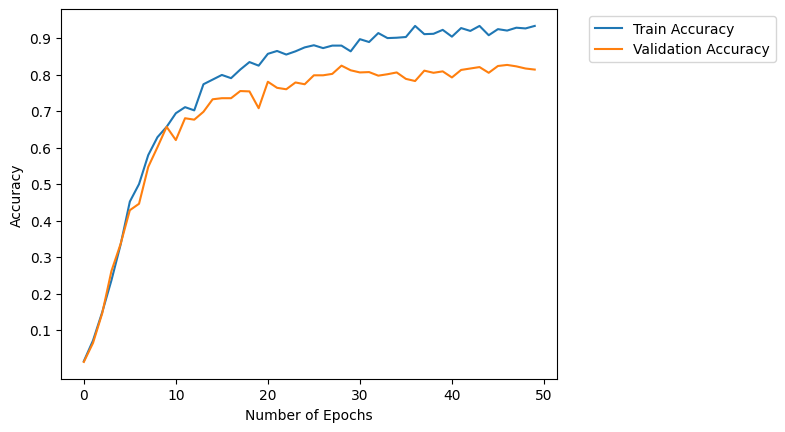

In [11]:
plt.plot(range(NUM_EPOCHS), train_accuracies, label="Train Accuracy")
plt.plot(range(NUM_EPOCHS), val_accuracies, label="Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.yticks(np.arange(0.1, 1, 0.1))
plt.show()

In [14]:
test_accuracy(model)

Number of correct preds: 4759
Test dataset total rows: 6149


0.77394700050354